## Escola Livre de IA 
### Dia 04 de Agosto de 2020
### Aula: Introdução a Redes Neurais com Keras/Tensorflow
#### Professor: Diego Duarte Menescal

#### Antes de começar, é necessário que o aluno tenha instalado o Python em seu computador.
#### Minha recomendação é instalar via Anaconda (https://www.anaconda.com/products/individual)
#### Depois disso, criar um Virtual Evironment segundo o Anaconda (conda create -n virtual_env)
#### Instalar o Python recente (conda install python) , Jupyter Notebook (pip install notebook) e Tensorflow (pip install tensorflow)
#### Abrir um terminal (prompt) que tenha o anaconda instalado. Windows Users = Anaconda Prompt
#### Entrar no Virtual Env: conda activate virt_env
#### Checar se o Python e Tensorflow foram instalados no Virtual Env: conda list
#### Abrir o Jupyter Notebook: jupyter notebook
## ==========================

### Nesta aula iremos apresentar como resolver um problema clássico de reconhecimento de dígitos numéricos utilizando dois modelos de redes neurais: O Perceptron de Múltiplas Camadas (MLP) e a Rede Neural Convolucional (CNN)
 
### Ambas as arquiteturas são do tipo FeedForward. 

#### OBS: Caso vocês tenham interesse nas recorrentes, teremos uma aula sobre elas com maiores detalhes com o prof. Victor Venites!!

### A base de dados se chama MNIST (http://yann.lecun.com/exdb/mnist/), e ela contém imagens de dígitos numéricos de 0 a 9 escritos manualmente!

### Seu download pode ser feito utilizando a biblioteca do Keras-Tensorflow! Para quem deseja começar, o Keras já possui vários datasets para aprender e testar! (https://keras.io/api/datasets/)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Utilizando a biblioteca do Keras para importar o dataset MNIST
from keras.datasets import mnist

### Aqui podemos extrair as bases de Treino e Teste! Vamos aproveitar e visualizar como é a base de dados:

In [44]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [26]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

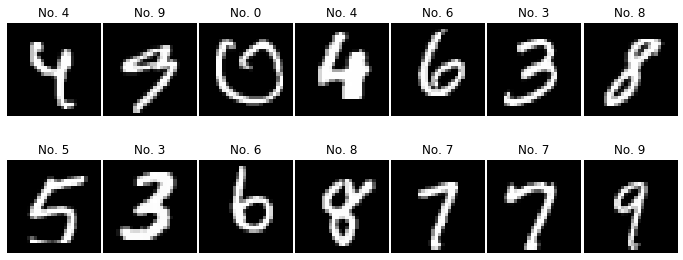

In [29]:
from matplotlib import pyplot as plt
np.random.seed(123)

rand_14 = np.random.randint(0, x_train.shape[0],14)
sample_digits = x_train[rand_14]
sample_labels = y_train[rand_14]
# code to view the images
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_digits[image_index], cmap='gray')
        ax[r,c].set_title('No. %d' % sample_labels[image_index])
plt.show()
plt.close()

### Podemos reparar que as amostras de cada imagem que constitui o dataset possui um formato bem definido:
### (x, y) > (28,28) = 28 x 28 pixels
### Além disso, cada pixel possui um valor que representa sua intensidade de cor (RGB) que varia entre 0 e 255.

### Agora vamos as definições das Arquiteturas:
### 1) MLP (Multi-Layer Perceptron):
#### Essa arquitetura possui 3 grandes camadas: Entrada, Oculta, Saída
#### Na Entrada, temos as imagens representadas acima. Um detalhe sobre as MLPs, é que o formato da entrada sempre é um tensor unidimensional. Portanto, uma imagem que é um tensor bidimensional será "vetorizado". Guarde bem essa condição!
#### Na Saída, temos um formato com 10 posições para classificar cada dígito em cada posição (Posição 0 = Dígito 0). Sendo assim, se uma entrada for o dígito 4 por exemplo, a posição 3 terá como valor ideal de 1 (100%), enquanto que os outros serão 0 (0%).
#### Já a camada Oculta será constituida dos Perceptrons fazendo todo o trabalho para aprender sobre essa base de dados. Cada camada Oculta (podem ser várias) possui a mesma função de ativação (sigmóide, limiar, afim, etc...) e um número de neurônios por camada.
### 1.1) Função Erro/Custo/Objetivo:
#### A escolha dessa função vai auxiliar no processo de Otimização Não-Linear Irrestrita, pois será ela que iremos otimizar no final de contas!!!
#### Pensando assim pode até parecer simples, mas toda a arquitetura da rede neural também é uma função, logo o resultado final é bastante complexo de se representar. 
### 1.2) Algoritmo de Aprendizagem/Otimização:
#### Após escolher a funcão Erro, precisamos escolhero algoritmo que vai otimizar os parâmetros da função erro, que por sua vez, calibram a RNA.
#### Aqui, o algoritmo segue um comportamento padrão: atualizações iterativas dos pesos sinápticos em função do erro.
#### A cada passo dado, o ajuste pode aumentar ou diminuir conforme os ajustes.

In [30]:
# Estilo de montagem do modelo de RNA Sequencial: quando criamos um modelo no Keras, ele possui um método chamado .Add()
# Logo o modelo vai juntando as camadas na sequencia das chamadas do método Add(). Considero ele mais intuitivo e mais fácil de
# trabalhar no dia a dia
from keras.models import Sequential

# Pacote do Keras das Camadas Ocultas: MLP. Ela se chama Dense pois tudo que é Entrada é conectada a todos os neurônios,
# tornando uma camada 100% conectada (também chamada de Fully Connected Layer - FC)
from keras.layers import Dense

# Pacote necessário para formatar a camada de saída do jeito descrito acima
from keras.utils import to_categorical

### Pré-processamento da Imagem
#### Aqui precisamos preparar a Entrada para funcionar corretamente na MLP. Caso isso não seja feito, resultados inesperados podem acontecer (assunto para outra aula mais específica...). Por isso, aqui é Regra: Normalização, Formatação devem ser feitas!
### 1) Formato e Cor
#### Como havíamos dito, o formato da entrada deve ser unidimensional.
#### Por fim, o valor da Cor (0 a 255) precisa ser convertido para um intervalo menor, de 0 a 1. 

In [45]:
# Tamanho do vetor de entrada
tamanho_vetor_entrada = 28*28

# Vetorização
x_train = x_train.reshape(x_train.shape[0], tamanho_vetor_entrada)
x_test = x_test.reshape(x_test.shape[0], tamanho_vetor_entrada)

# Normalização
# Fase 1: Conversão de RGB para Escala de Cinza (GreyScale)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Fase 2: Normalização Max-Min: (0-255) para (0-1)
x_train /= 255
x_test /= 255

# Criação do Formato da Saída do modelo utilizando o Keras:
# São 10 possíveis saídas, representadas por 10 posições
# Valor 1 se for a saída certa, 0 senão
# Isso se chama Categorização da Saída
numero_classes = 10 #Cada classe é um digíto
y_train = to_categorical(y_train, numero_classes)
y_test = to_categorical(y_test, numero_classes)

In [55]:
# Criação do Modelo MLP
mlp = Sequential()

# Conexão da Camada de Entrada (input_shape) com a Primeira Camada Escondida.Função de Ativação Sigmóide.
mlp.add(Dense(512, 
              input_shape=(tamanho_vetor_entrada,), # Tamanho do vetor: 28x28 = 764 posições
              activation='sigmoid'))

# Segunda camada Oculta. Como ela se conecta com outra camada Oculta, não precisa passar o tamanho.
mlp.add(Dense(512, activation='sigmoid'))

# Camada de Saída. Sua função de Ativação é adequada para um problema de classificação como este.
# Como temos uma saída em formato categórico, essa função é recomendada.
mlp.add(Dense(numero_classes, activation='softmax'))

mlp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Definições da função Erro, Otimização e Parâmetros de Treinamento
mlp.compile(loss='categorical_crossentropy', # Função Erro mais adequada para 
              optimizer='SGD', 
              metrics=['accuracy'])

history = mlp.fit(x_train, y_train,
                    batch_size=128, # Bloco do Dataset a ser treinado por iteração
                    epochs=20, # Quantas vezes o treinamento varre o Dataset completamente
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/20
469/469 [==============================] - 5s 10ms/step - loss: 2.2660 - accuracy: 0.2131 - val_loss: 2.2248 - val_accuracy: 0.3499
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 2.1830 - accuracy: 0.4068 - val_loss: 2.1302 - val_accuracy: 0.6736
Epoch 3/20
469/469 [==============================] - 5s 10ms/step - loss: 2.0727 - accuracy: 0.5439 - val_loss: 1.9950 - val_accuracy: 0.6439
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 1.9102 - accuracy: 0.6240 - val_loss: 1.7972 - val_accuracy: 0.6541
Epoch 5/20
469/469 [==============================] - 5s 10ms/step - loss: 1.6848 - accuracy: 0.6712 - val_loss: 1.5452 - val_accuracy: 0.7134
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 1.4316 - accuracy: 0.7143 - val_loss: 1.2952 - val_accuracy: 0.7366
Epoch 7/20
469/469 [==============================] - 4s 9ms/step - loss: 1.2055 - accuracy: 0.7466 - val_loss: 1.0969 - val_accuracy: 0.7652
Ep

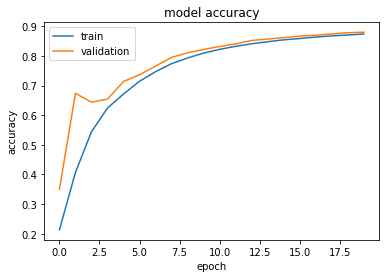

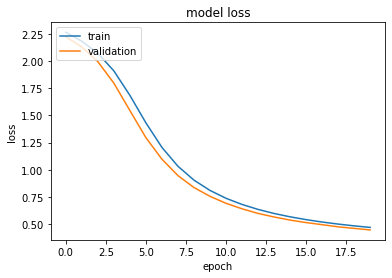

In [58]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [60]:
# Test the model after training
test_results = mlp.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

313/313 [==============================] - 1s 2ms/step - loss: 0.4451 - accuracy: 0.8796
Test results - Loss: 0.44513025879859924 - Accuracy: 87.95999884605408%


### Segundo modelo: CNN
#### Este modelo de RNA, ao contrário da MLP, possui uma característica muito especial: Ela possui camadas de extração de características ocultas nas imagens! Essas camadas se chamam de Convolucionais.
#### Outro ponto a se falar sobre a Convolução é o uso de filtros, também chamados de Kernel. Eles possuem uma dimensão menor que a entrada e servem para "iluminar" a área da imagem que eu quero extrair possíveis características. Podemos pensar numa máscara também, para ajudar no entendimento.
#### Sua arquitetura se resume numa sequencia inicial de convoluções, também chamada de extração de características ("Feature Extraction"), seguida de uma MLP. 
#### Ora essa, então no final das contas, tudo que for extraído nas convoluções será vetorizado mais a frente? Isso mesmo!!!
#### Mas uma imensa diferença existe aqui comparada com uma MLP pura: a CNN preserva e busca aprender as RELAÇÕES ESPACIAIS contidas na imagem. Curvas, contornos, contrastes e outras características serão tratadas como informação importante para ser aprendida. Na MLP, a vetorização direta da imagem elimina essas relações espaciais. 
#### Mesmo que ambos os modelos performem bem (alta acurácia, baixo erro), cada uma tem o seu escopo de aplicação.
#### MLPs : Previsão de números. Ele é um super modelo de regressão numérica. 
#### CNNs: Reconhecimento de padrões em dados multi-dimensionais.
### Sendo assim, vamos refazer nosso modelo Keras! Agora mais rápido!

In [64]:
from keras.layers import Dense, Conv2D, Flatten
dimensao_imagem = 28
dimensao_filtro_convolucao = 3

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=dimensao_filtro_convolucao, 
               activation='sigmoid', 
               input_shape=(dimensao_imagem,dimensao_imagem,1))) # Tamanho da entrada: 28 por 28 por 1 (canal de cor)
cnn.add(Conv2D(32, kernel_size=dimensao_filtro_convolucao, activation='sigmoid'))

# Camada que vetoriza todas as características extraídas
cnn.add(Flatten())
cnn.add(Dense(numero_classes, activation='softmax'))
cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                184330    
Total params: 203,434
Trainable params: 203,434
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Definições da função Erro, Otimização e Parâmetros de Treinamento
cnn.compile(loss='categorical_crossentropy', # Função Erro mais adequada para 
              optimizer='SGD', 
              metrics=['accuracy'])

history = cnn.fit(x_train, y_train,
                    batch_size=128, # Bloco do Dataset a ser treinado por iteração
                    epochs=20, # Quantas vezes o treinamento varre o Dataset completamente
                    verbose=1,
                    validation_data=(x_test, y_test))

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test the model after training
test_results = mlp.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

# Muito Obrigado a Todos! Espero que tenham gostado!
## Segue o meu contato para dúvidas, conversas e recomendações:
### Email: dmenescal@outlook.com
### Telefone(zap): 0 11 998681314
### Linkedin: https://www.linkedin.com/in/diegomenescal/
### Canal - Youtube: Doutor IA